In [38]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


file_path = "earthquakes.csv"
earthquakes_df = pd.read_csv(file_path)



In [39]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [41]:
# Selecting relevant columns for model training
selected_columns = ['magnitude', 'depth', 'time', 'latitude', 'longitude']
df_cleaned = df[selected_columns].copy()


In [42]:
# Converting timestamp from milliseconds to seconds
df_cleaned['time'] = df_cleaned['time'] / 1000

In [43]:
# Normalizing magnitude, depth, and time using Min-Max scaling
scaler = MinMaxScaler()
df_cleaned[['magnitude', 'depth', 'time']] = scaler.fit_transform(df_cleaned[['magnitude', 'depth', 'time']])

In [44]:
# Appling K-Means Clustering for location-based grouping
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cleaned['location_cluster'] = kmeans.fit_predict(df_cleaned[['latitude', 'longitude']])

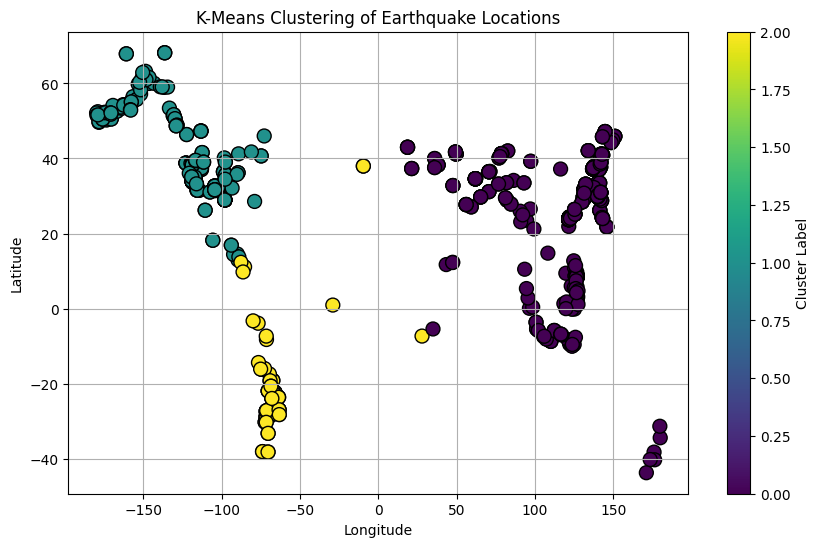

In [45]:
# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['longitude'], df_cleaned['latitude'], c=df_cleaned['location_cluster'], cmap='viridis', marker='o', edgecolor='k', s=100)
plt.title('K-Means Clustering of Earthquake Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

In [46]:
# Drop latitude & longitude after clustering
df_cleaned.drop(columns=['latitude', 'longitude'], inplace=True)

In [47]:
# Split dataset into inputs (X) and outputs (Y)
X = df_cleaned.drop(columns=['magnitude']).values  # Input features
y_magnitude = df_cleaned['magnitude'].values  # Output 1: Magnitude (Regression)
y_time = df_cleaned['time'].values  # Output 2: Time (Regression)
y_location = df_cleaned['location_cluster'].values  # Output 3: Location (Classification)

In [48]:
# Split into training and testing sets
X_train, X_test, y_m_train, y_m_test, y_t_train, y_t_test, y_l_train, y_l_test = train_test_split(
    X, y_magnitude, y_time, y_location, test_size=0.2, random_state=42
)

In [49]:
# Converting to PyTorch tensors
X_train, X_test = torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(X_test, dtype=torch.float32).to(device)
y_m_train, y_m_test = torch.tensor(y_m_train, dtype=torch.float32).to(device), torch.tensor(y_m_test, dtype=torch.float32).to(device)
y_t_train, y_t_test = torch.tensor(y_t_train, dtype=torch.float32).to(device), torch.tensor(y_t_test, dtype=torch.float32).to(device)
y_l_train, y_l_test = torch.tensor(y_l_train, dtype=torch.long).to(device), torch.tensor(y_l_test, dtype=torch.long).to(device)


In [50]:
# Create DataLoader for batch processing
batch_size = 32
train_dataset = TensorDataset(X_train, y_m_train, y_t_train, y_l_train)
test_dataset = TensorDataset(X_test, y_m_test, y_t_test, y_l_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

This Attention class implements a simple attention mechanism that computes attention scores for a given input, normalizes these scores to obtain attention weights, and produces a weighted sum of the input features based on these weights. This mechanism is commonly used in various neural network architectures, especially in natural language processing and sequence modeling tasks.

In [51]:
#Attention Layer
class Attention(nn.Module):
    def __init__(self, input_dim):
        super(Attention, self).__init__()
        self.attention_weights = nn.Linear(input_dim, 1)

    def forward(self, x):
        attention_scores = torch.tanh(self.attention_weights(x))
        attention_weights = torch.softmax(attention_scores, dim=1)
        attended_output = torch.sum(x * attention_weights, dim=1)
        return attended_output


The code defines an EarthquakeLSTM class, which is a neural network model built using PyTorch. This model is designed to predict three outputs related to earthquakes: magnitude, timestamp, and location.

Key Components:
LSTM Layer: The model uses an LSTM (Long Short-Term Memory) layer to process sequential input data, which is suitable for time-series predictions.
Attention Mechanism: An attention layer is integrated to enhance the model's ability to focus on relevant parts of the LSTM output, improving prediction accuracy.

Fully Connected Layers: Separate fully connected layers are defined for each prediction task (magnitude, timestamp, and location). The magnitude and timestamp outputs are produced directly, while the location output is passed through a softmax function to yield a probability distribution over possible locations.

Forward Pass:
In the forward method, the input data is processed through the LSTM, followed by the attention mechanism, and then through the respective fully connected layers to generate the three outputs.

Overall, this model combines LSTM and attention mechanisms to effectively predict earthquake characteristics based on sequential input data.

In [52]:
#Attention-Based LSTM Model
class EarthquakeLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim_m, output_dim_t, output_dim_l):
        super(EarthquakeLSTM, self).__init__()

        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.attention = Attention(hidden_dim)

        # Magnitude prediction
        self.magnitude_fc1 = nn.Linear(hidden_dim, 50)
        self.magnitude_fc2 = nn.Linear(50, output_dim_m)

        # Timestamp prediction
        self.timestamp_fc1 = nn.Linear(hidden_dim, 50)
        self.timestamp_fc2 = nn.Linear(50, output_dim_t)

        # Location prediction (classification)
        self.location_fc1 = nn.Linear(hidden_dim, 50)
        self.location_fc2 = nn.Linear(50, output_dim_l)

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))  # Adding batch dimension
        attention_out = self.attention(lstm_out)

        # Magnitude output
        mag_out = torch.relu(self.magnitude_fc1(attention_out))
        mag_out = self.magnitude_fc2(mag_out)

        # Timestamp output
        time_out = torch.relu(self.timestamp_fc1(attention_out))
        time_out = self.timestamp_fc2(time_out)

        # Location output
        loc_out = torch.relu(self.location_fc1(attention_out))
        loc_out = F.softmax(self.location_fc2(loc_out), dim=1)

        return mag_out, time_out, loc_out

In [53]:
# Model Parameters
input_dim = X_train.shape[1]
hidden_dim = 100
output_dim_m = 1  # Magnitude
output_dim_t = 1  # Timestamp
output_dim_l = 3  # Location classification

In [54]:
# Initialize Model
model = EarthquakeLSTM(input_dim, hidden_dim, output_dim_m, output_dim_t, output_dim_l).to(device)

In [55]:
# Loss Functions
loss_magnitude = nn.MSELoss()
loss_timestamp = nn.MSELoss()
loss_location = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [56]:
# Training Loop
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_m_batch, y_t_batch, y_l_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        mag_pred, time_pred, loc_pred = model(X_batch)

        # Compute losses
        loss_m = loss_magnitude(mag_pred.squeeze(), y_m_batch)
        loss_t = loss_timestamp(time_pred.squeeze(), y_t_batch)
        loss_l = loss_location(loc_pred, y_l_batch)

        total_loss = loss_m + loss_t + loss_l
        total_loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss.item():.4f}')

Epoch [1/100], Loss: 1.4984
Epoch [2/100], Loss: 1.1035
Epoch [3/100], Loss: 1.0389
Epoch [4/100], Loss: 0.7784
Epoch [5/100], Loss: 0.7469
Epoch [6/100], Loss: 0.6005
Epoch [7/100], Loss: 0.5794
Epoch [8/100], Loss: 0.8060
Epoch [9/100], Loss: 0.6564
Epoch [10/100], Loss: 0.5645
Epoch [11/100], Loss: 0.7152
Epoch [12/100], Loss: 0.7991
Epoch [13/100], Loss: 0.6395
Epoch [14/100], Loss: 0.5950
Epoch [15/100], Loss: 0.6402
Epoch [16/100], Loss: 0.5564
Epoch [17/100], Loss: 0.5628
Epoch [18/100], Loss: 0.5789
Epoch [19/100], Loss: 0.5617
Epoch [20/100], Loss: 0.5713
Epoch [21/100], Loss: 0.7207
Epoch [22/100], Loss: 0.6356
Epoch [23/100], Loss: 0.5969
Epoch [24/100], Loss: 0.6422
Epoch [25/100], Loss: 0.5654
Epoch [26/100], Loss: 0.6404
Epoch [27/100], Loss: 0.5598
Epoch [28/100], Loss: 0.5761
Epoch [29/100], Loss: 0.6635
Epoch [30/100], Loss: 0.5595
Epoch [31/100], Loss: 0.5753
Epoch [32/100], Loss: 0.5721
Epoch [33/100], Loss: 0.5550
Epoch [34/100], Loss: 0.5762
Epoch [35/100], Loss: 0

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to compute RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Switch to evaluation mode
model.eval()
with torch.no_grad():
    # Get predictions
    mag_pred, time_pred, loc_pred = model(X_test)

    # Convert tensors to NumPy arrays for evaluation
    y_m_test_np = y_m_test.cpu().numpy()
    y_t_test_np = y_t_test.cpu().numpy()
    y_l_test_np = y_l_test.cpu().numpy()

    mag_pred_np = mag_pred.cpu().numpy().squeeze()
    time_pred_np = time_pred.cpu().numpy().squeeze()
    loc_pred_np = loc_pred.cpu().numpy()

    # Get predicted class for location
    y_l_pred_classes = loc_pred_np.argmax(axis=1)

    # Compute Metrics for Magnitude Prediction
    print("\n Magnitude Prediction:")
    print("MSE:", mean_squared_error(y_m_test_np, mag_pred_np))
    print("MAE:", mean_absolute_error(y_m_test_np, mag_pred_np))
    print("RMSE:", rmse(y_m_test_np, mag_pred_np))
    print("R²:", r2_score(y_m_test_np, mag_pred_np))

    # Compute Metrics for Time Prediction
    print("\n Time Prediction:")
    print("MSE:", mean_squared_error(y_t_test_np, time_pred_np))
    print("MAE:", mean_absolute_error(y_t_test_np, time_pred_np))
    print("RMSE:", rmse(y_t_test_np, time_pred_np))
    print("R²:", r2_score(y_t_test_np, time_pred_np))

    # Compute Accuracy for Location Classification
    location_accuracy = (y_l_pred_classes == y_l_test_np).mean()

    print("\n Location Prediction (Classification):")
    print("Accuracy:", location_accuracy)



 Magnitude Prediction:
MSE: 0.009707950986921787
MAE: 0.0727563127875328
RMSE: 0.09852893477005517
R²: 0.8096438646316528

 Time Prediction:
MSE: 8.094001714198384e-06
MAE: 0.0022635271307080984
RMSE: 0.00284499590758904
R²: 0.999909520149231

 Location Prediction (Classification):
Accuracy: 0.9078947368421053


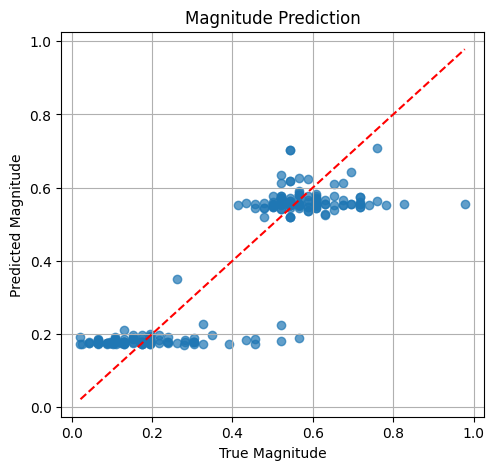

In [63]:
# Visualization
# 1. Magnitude Prediction
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_m_test_np, mag_pred_np, alpha=0.7)
plt.plot([y_m_test_np.min(), y_m_test_np.max()], [y_m_test_np.min(), y_m_test_np.max()], 'r--')  # Diagonal line
plt.title('Magnitude Prediction')
plt.xlabel('True Magnitude')
plt.ylabel('Predicted Magnitude')
plt.grid(True)



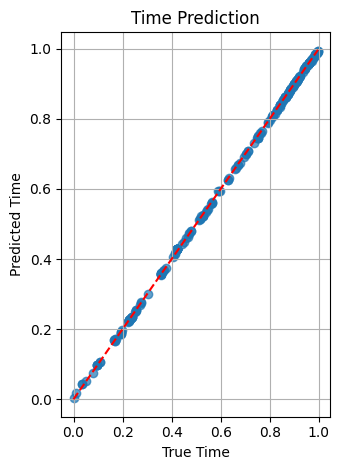

In [61]:
    # 2. Time Prediction
plt.subplot(1, 2, 2)
plt.scatter(y_t_test_np, time_pred_np, alpha=0.7)
plt.plot([y_t_test_np.min(), y_t_test_np.max()], [y_t_test_np.min(), y_t_test_np.max()], 'r--')  # Diagonal line
plt.title('Time Prediction')
plt.xlabel('True Time')
plt.ylabel('Predicted Time')
plt.grid(True)

plt.tight_layout()
plt.show()



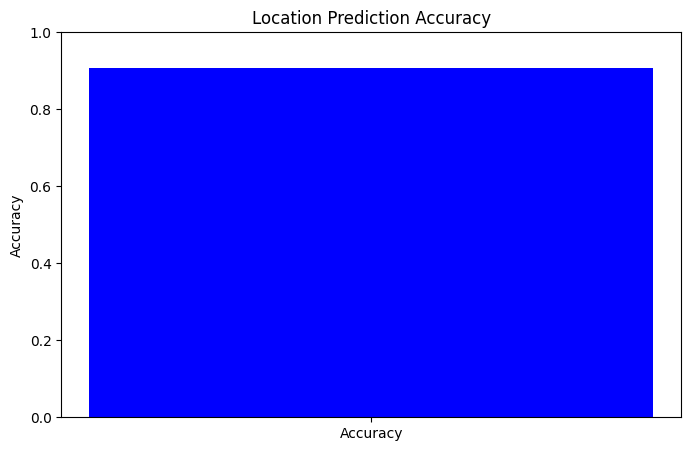

In [62]:
    # 3. Location Prediction Accuracy
plt.figure(figsize=(8, 5))
plt.bar(['Accuracy'], [location_accuracy], color='blue')
plt.ylim(0, 1)
plt.title('Location Prediction Accuracy')
plt.ylabel('Accuracy')
plt.show()